<a href="https://colab.research.google.com/github/minjaecd123/study/blob/master/20250326_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[비지도 학습 기반 음식군 클러스터링 + 지도 학습 기반 예측 모델]

#기온, 습도, 강수량, 월, 요일 등의 환경 정보를 기반으로 음식 검색량 패턴(Log 변환)을 클러스터링하고, 그 클러스터를 예측하는 머신러닝 분류 모델



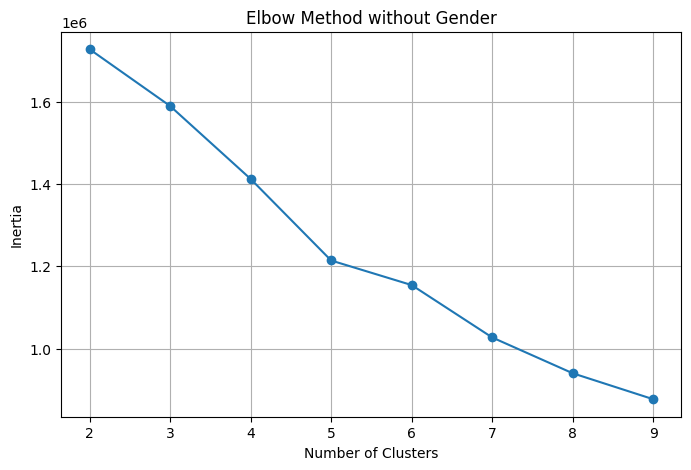

✔ Silhouette Score 계산 중... (샘플 사용)

🔍 Silhouette Score (샘플 5000개 기준): 0.2553

🎯 정확도: 0.9709971533479104

📋 분류 리포트:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     25723
           1       0.98      0.98      0.98      9690
           2       0.96      0.96      0.96     17637
           3       0.96      0.96      0.96     18205
           4       1.00      1.00      1.00      1462

    accuracy                           0.97     72717
   macro avg       0.98      0.98      0.98     72717
weighted avg       0.97      0.97      0.97     72717



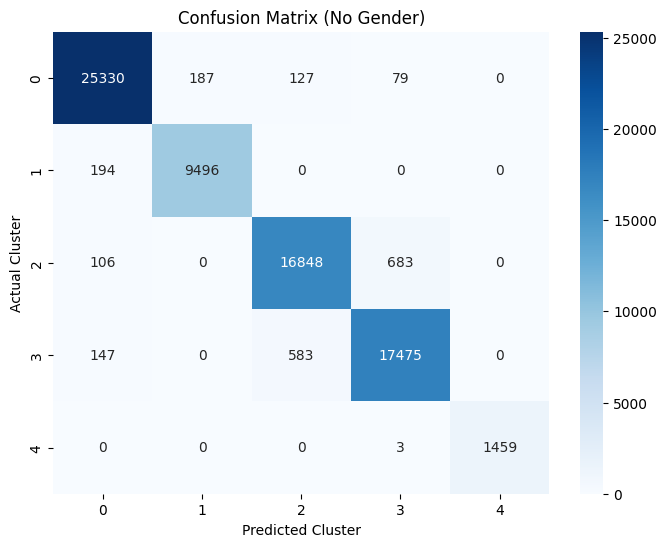

<ipython-input-1-3b914cbf1679>:93: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


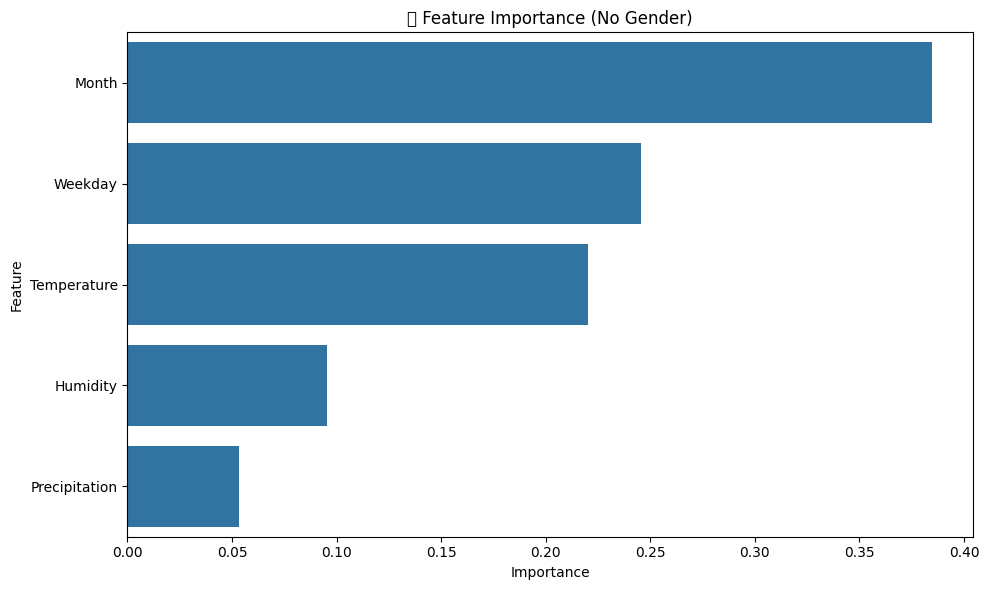


📊 클러스터별 평균 특성:
               Temperature   Humidity  Precipitation      Month   Weekday
Cluster_Label                                                            
0                24.164218  73.120258       2.959154   7.797695  3.157239
1                 6.577257  57.733808       0.793170  11.420619  2.830774
2                 7.141024  63.929066       2.318609   2.570845  1.183228
3                 7.184790  56.104674       0.712027   2.460993  4.583468
4                21.996553  89.002913      74.544563   7.194912  3.215018

🧑 입력한 조건은 클러스터 3에 속합니다.


np.int32(3)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/ai/alone/merge_trends_weather_long_ml.csv')

# 2. 날짜 전처리 및 결측치 처리
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%m-%d')
df['Precipitation'] = df['Precipitation'].replace(-9.0, np.nan).fillna(0)

# 3. 로그 변환된 Search_Count 생성
df['Log_Search_Count'] = np.log1p(df['Search_Count'])

# 4. 클러스터링용 피처 (성별 제거)
features_for_cluster = ['Log_Search_Count', 'Temperature', 'Humidity', 'Precipitation', 'Month', 'Weekday']
X_cluster = df[features_for_cluster]

# 5. 예측용 피처 (Search_Count, Gender 제외)
features_for_predict = ['Temperature', 'Humidity', 'Precipitation', 'Month', 'Weekday']
X_predict = df[features_for_predict]

# 6. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 7. Elbow Method
inertias = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method without Gender')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 8. 클러스터링 수행
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# ✅ 9. Silhouette Score 평가 (샘플링)
print("✔ Silhouette Score 계산 중... (샘플 사용)")
sample_size = 5000
X_sample = X_scaled[:sample_size]
labels_sample = df['Cluster_Label'][:sample_size]
sil_score = silhouette_score(X_sample, labels_sample)
print(f"\n🔍 Silhouette Score (샘플 {sample_size}개 기준): {sil_score:.4f}")

# 10. 예측 모델 학습
X = X_predict
y = df['Cluster_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# 11. 평가
y_pred = clf.predict(X_test)
print("\n🎯 정확도:", accuracy_score(y_test, y_pred))
print("\n📋 분류 리포트:\n", classification_report(y_test, y_pred))

# 12. 혼동 행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Gender)')
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Cluster')
plt.show()

# 13. 피처 중요도
importances = clf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('📌 Feature Importance (No Gender)')
plt.tight_layout()
plt.show()

# 14. 클러스터별 평균 특성
print("\n📊 클러스터별 평균 특성:")
print(df.groupby('Cluster_Label')[features_for_predict].mean())

# 15. 사용자 입력 예측
def predict_user_cluster(input_dict):
    input_df = pd.DataFrame([input_dict])
    predicted_cluster = clf.predict(input_df)[0]
    print(f"\n🧑 입력한 조건은 클러스터 {predicted_cluster}에 속합니다.")
    return predicted_cluster

# 16. 사용자 예시 입력 (성별 제거됨)
user_input = {
    'Temperature': 12.5,
    'Humidity': 60.0,
    'Precipitation': 0.0,
    'Month': 3,
    'Weekday': 5
}
predict_user_cluster(user_input)


# 결과 분석 보고서

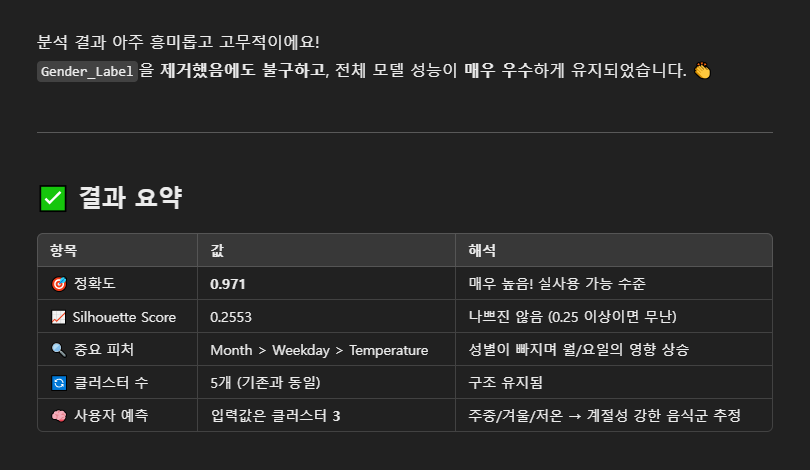

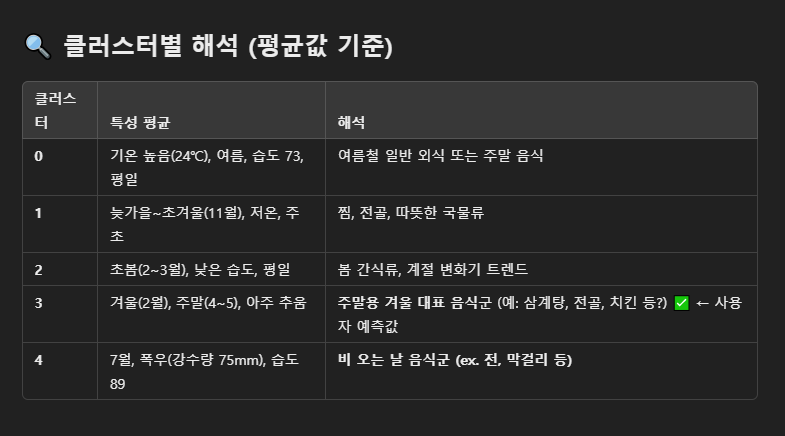

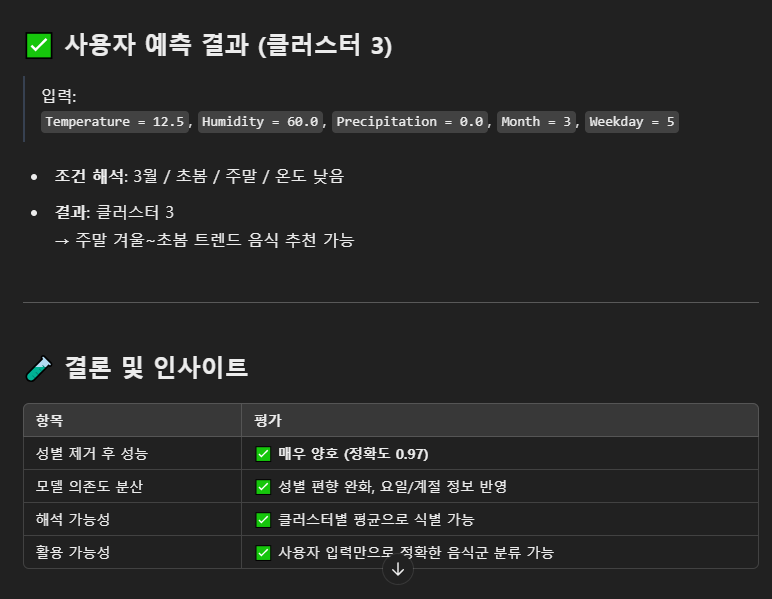

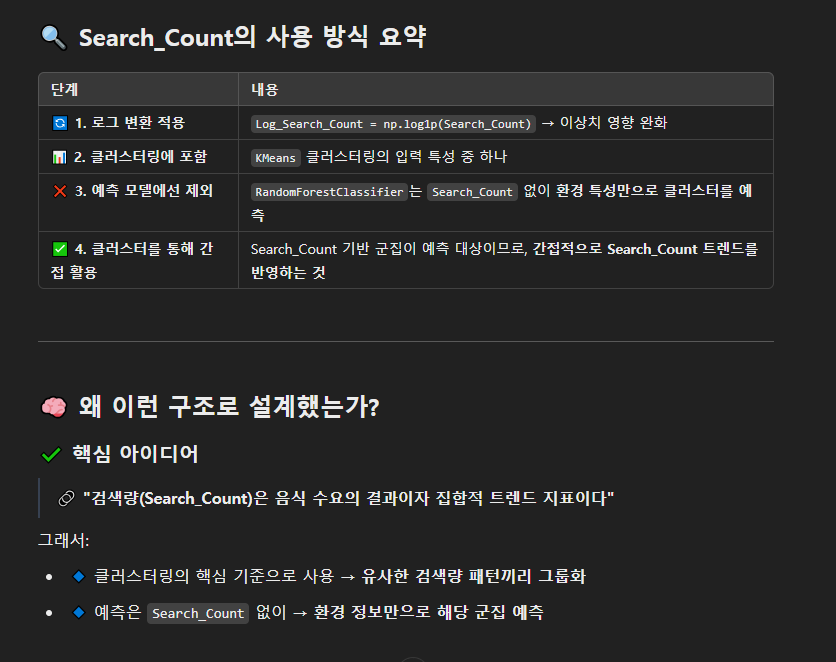